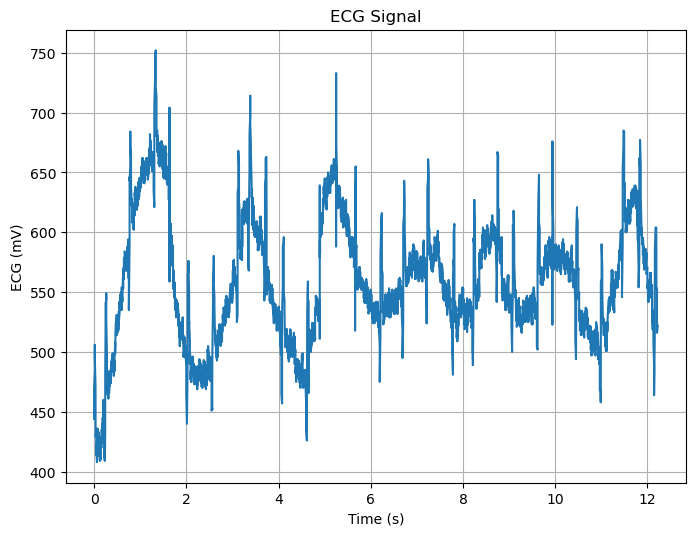

In [2]:
import serial.tools.list_ports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
import time
from scipy.signal import butter, lfilter
import neurokit2 as nk
from ecgdetectors import Detectors
import pandas as pd
import heartpy as hp
from heartpy.datautils import rolling_mean
from scipy.interpolate import interp1d
import wfdb
from wfdb import processing
import scipy.signal as sig
import math
import scipy.signal as scs
import peakutils
from numpy import genfromtxt
from scipy.signal import find_peaks
from scipy.signal import butter,filtfilt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import serial.tools.list_ports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
import time
from scipy.signal import butter, lfilter
import neurokit2 as nk
from ecgdetectors import Detectors
import pandas as pd
import heartpy as hp
from heartpy.datautils import rolling_mean
from scipy.interpolate import interp1d
import wfdb
from wfdb import processing
import scipy.signal as sig
import math
import scipy.signal as scs
import peakutils
from scipy.signal import find_peaks

namer="My_new_ECG_data_Mi109and106bpm_Manual108.996bpm.csv"


daty = genfromtxt(namer, delimiter=',')

init=1
explode=daty.shape[0]
ecg_ref_data=daty[init:explode,1]
ecg=ecg_ref_data
timer=daty[1:(explode-init)+1,2]
inst_fs=1/np.diff(timer)
inst_fs[inst_fs > 175000] = 0


segment_length=3000
err_record=[]
for i in range(len(inst_fs)-segment_length+1):
    temp_inst_fs=inst_fs[i:i+segment_length]
    err_record.append(np.std(temp_inst_fs))

val, idx = min((val, idx) for (idx, val) in enumerate(err_record))

init=idx
explode=idx+segment_length
ecg_ref_data=daty[init:explode,1]
ecg=ecg_ref_data
timer=daty[1:(explode-init)+1,2]
inst_fs=1/np.diff(timer)
inst_fs[inst_fs > 175000] = 0


fs_mean=np.mean(inst_fs)
fs_std=np.std(inst_fs)
fs = (np.mean(inst_fs)*6)
# fs=(fs_std)/3+fs_mean
length=11
order=7
length2=11
order2=7
detrended_ecg=signal.detrend(ecg)
denoised_detrended_ecg=savgol_filter(detrended_ecg,length, order)
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

b, a = butter_highpass(14/60, 10, order=2)
final_ecg = signal.filtfilt(b, a, denoised_detrended_ecg)
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)
plt.plot(timer,ecg)
plt.xlabel('Time (s)')
plt.ylabel('ECG (mV)')
plt.title('ECG Signal')
plt.grid()



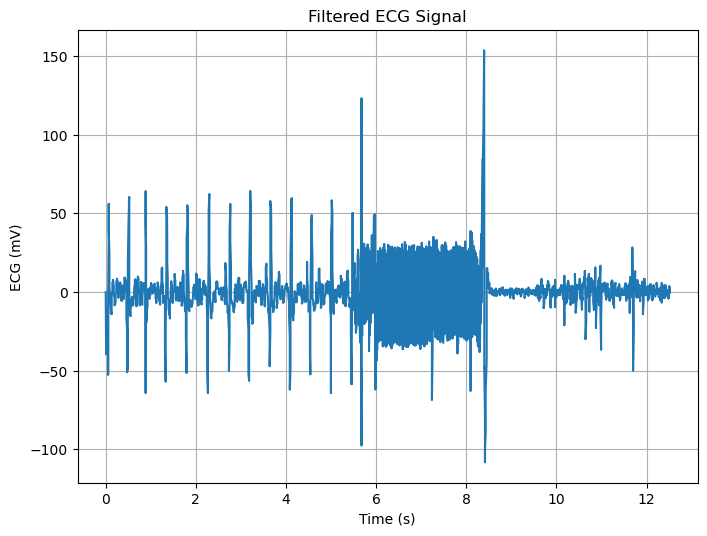

In [572]:
figure(figsize=(8, 6), dpi=100)
plt.plot(timer,final_ecg)
plt.xlabel('Time (s)')
plt.ylabel('ECG (mV)')
plt.title('Filtered ECG Signal')
plt.grid()

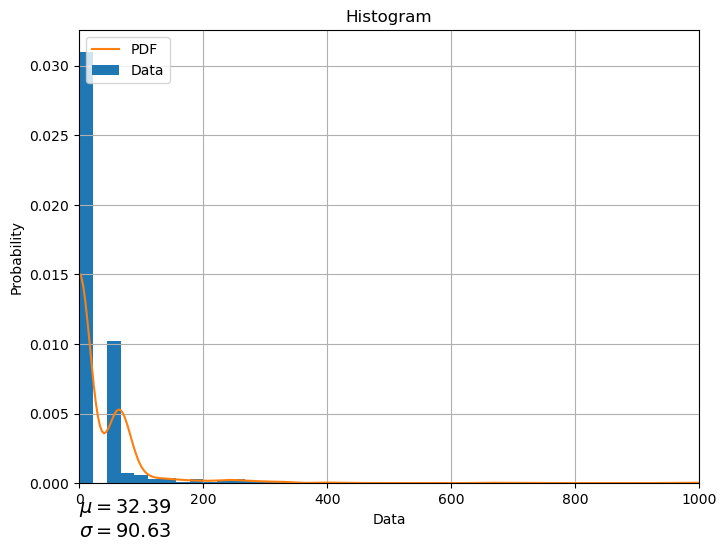

In [573]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import scipy.stats as st
figure(figsize=(8, 6), dpi=100)

# q25, q75 = np.percentile(inst_fs, [25, 75])
# bin_width = 2 * (q75 - q25) * len(inst_fs) ** (-1/3)
# bins = round((np.max(inst_fs) - np.min(inst_fs)) / bin_width)


# plt.hist(inst_fs, density=True, bins=100)
# plt.ylabel('Probability')
# plt.xlabel('Amplitude')


plt.hist(inst_fs, density=True, bins=100, label="Data")
# fs_mean=np.mean(inst_fs)
# fs_std=np.std(inst_fs)
fs_median=np.median(inst_fs)
mn=0
mx=1000
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(inst_fs)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability")
plt.xlabel("Data")
plt.title("Histogram")
textstr = '\n'.join((
    r'$\mu=%.2f$' % (fs_mean, ),
    r'$\sigma=%.2f$' % (fs_std, )))
plt.text(0.0, -0.001, textstr, fontsize=14,
        verticalalignment='top')
plt.grid()

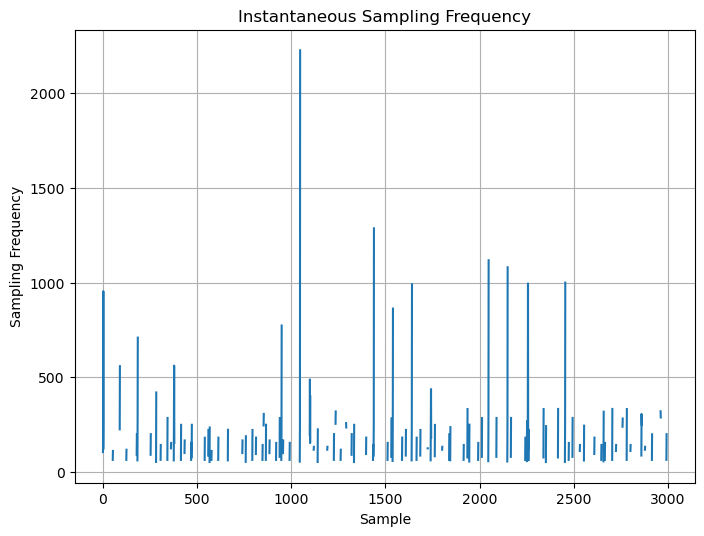

In [574]:
figure(figsize=(8, 6), dpi=100)
plt.plot(1/np.diff(timer))
plt.xlabel('Sample')
plt.ylabel('Sampling Frequency')
plt.title('Instantaneous Sampling Frequency')
plt.grid()

Method#01

In [4]:
# https://github.com/paulvangentcom/heartrate_analysis_python/blob/master/examples/2_regular_ECG/Analysing_a_regular_ECG_signal.ipynb
wd, m = hp.process(final_ecg, sample_rate = fs)
resp=m['breathingrate']*60
print("Respiration Rate: ",resp)

Respiration Rate:  11.924478304074196


Method#02

In [19]:
#  Refer: 
            # 1. Charlton, et al. "Breathing rate estimation from the electrocardiogram and photoplethysmogram: A review." IEEE reviews in biomedical engineering 11 (2017)
            # 2. Schäfer, Axel, and Karl W. Kratky. "Estimation of breathing rate from respiratory sinus arrhythmia: comparison of various methods." Annals of Biomedical Engineering 36,(2008)
lowcut = 35
highcut = 45

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

ecg_bandpass = butter_bandpass_filter(final_ecg, lowcut, highcut, fs, order=4)
"""
Capping all maxima values to be greater than 0.2*(3rd quantile) and minima less than (1st quantile) as describes in [2]. 
Procedure describes in [2], "Estimation of breathing rate from respiratory sinus arrhythmia: comparison of various methods.", Schäfer et al.  
"""

maxIndices=argrelextrema(ecg_bandpass, np.greater)
minIndices=argrelextrema(ecg_bandpass, np.less)
#Getting max and min lists. 
maximum_values = ecg_bandpass[maxIndices]
minimum_values = ecg_bandpass[minIndices]

#Find the respective quantiles. 
maximum_bandpass_thirdquantile = np.quantile(maximum_values, 0.75)
minimum_bandpass_thirdquantile = np.quantile(minimum_values, 0.25)


#Banding the maxima and minima within these quantiles. 
maximums_banded=[]
minimum_banded=[]
for i in maxIndices[0]:
    if np.any(ecg_bandpass[i] > 0.2*maximum_bandpass_thirdquantile):
        maximums_banded.append(i)

for i in minIndices[0]:
    if np.any(ecg_bandpass[i] < 0.2*minimum_bandpass_thirdquantile):
        minimum_banded.append(i)


valid_resp_cycle = []

extremum_banded_list = maximums_banded + minimum_banded

extremum_banded_list.sort()

for i in range(1,len(extremum_banded_list)-1):
    if (ecg_bandpass[ extremum_banded_list[i] ] < ecg_bandpass[extremum_banded_list[i-1] ] and ecg_bandpass[ extremum_banded_list[i] ] < ecg_bandpass[extremum_banded_list[i+1] ] 
        and ecg_bandpass[ extremum_banded_list[i] ] < 0 and ecg_bandpass[extremum_banded_list[i-1]] > 0
        and ecg_bandpass[extremum_banded_list[i+1]] >0):
        
        valid_resp_cycle += [extremum_banded_list[i-1], extremum_banded_list[i], extremum_banded_list[i+1]]


# Calculating breathing rate from extremum points. 
br = []
for x in range(0, len(valid_resp_cycle)-2, 3):
    br.append(60/(valid_resp_cycle[x+2] - valid_resp_cycle[x]) ) #breaths per minute. 300 to rescale x-axis in seconds. 

br=np.array(br)
breathingrate=np.mean(br)
print("Breathing Rate: ",breathingrate)

Breathing Rate:  11.54127590388921


Method#03

In [22]:
# https://neurokit2.readthedocs.io/en/latest/functions.html


# van Gent, P., Farah, H., van Nes, N., & van Arem, B. (2019). HeartPy: A novel heart rate algorithm for the analysis of noisy signals.
#  Transportation research part F: traffic psychology and behaviour, 66, 368-378.

breather=nk.ecg_rsp(final_ecg, sampling_rate=fs, method="vangent2019")          
maxIndices_breather=argrelextrema(breather, np.greater)
maxIndices_breather=np.squeeze(maxIndices_breather,axis=0)
msPerBeat_breather = np.mean(np.diff(timer[maxIndices_breather]))
Rate_breather = 60*1/(msPerBeat_breather)*2
print("Breathing Rate: ",Rate_breather)

Breathing Rate:  15.653481763995396


Method#04

In [41]:
# Refer: https://www.degruyter.com/document/doi/10.1515/cdbme-2015-0016/html?lang=en

sos = signal.butter(5, 20, 'lp', fs=fs, output='sos')
filtered_low= signal.sosfilt(sos, final_ecg)
sos = signal.butter(4, 20, 'hp', fs=fs, output='sos')
filtered_high= signal.sosfilt(sos, filtered_low)

framized_ecg = pd.DataFrame(filtered_high, columns = ['ECG'])
detectors = Detectors(fs)
r_peaks_pan = detectors.pan_tompkins_detector(framized_ecg.iloc[:,0])
r_peaks_pan= np.asarray(r_peaks_pan)

s=filtered_high
for i in range(len(filtered_high)):
    if i in r_peaks_pan:
        s[i] = s[i]
    else:
        s[i] = 0



# plt.plot(timer,s)
# plt.show()
q_u = np.zeros(s.shape)
u_x = [0,]
u_y = [s[0],]

for k in range(1,len(s)-1):
    if (np.sign(s[k]-s[k-1])==1) and (np.sign(s[k]-s[k+1])==1):
        u_x.append(k)
        u_y.append(s[k])


u_x.append(len(s)-1)
u_y.append(s[-1])

u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
for k in range(0,len(s)):
    q_u[k] = u_p(k)

# plt.plot(q_u)
# plt.plot(s)
# plt.show()
maxIndices_r=argrelextrema(q_u, np.greater)
maxIndices_r=np.squeeze(maxIndices_r,axis=0)
msPerBeat_r = np.mean(np.diff(timer[maxIndices_r]))
rheartRate_new_r = 60*(1/msPerBeat_r)
print("Breathing Rate: ",rheartRate_new_r)

Breathing Rate:  14.440956183218145
